In [295]:
%load_ext autoreload
%autoreload 2

from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline
import json
import pickle
import os
import sys
sys.path.append('../..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.manage_orderbooks import *
from helper.evaluation import evaluate, plot_evaluation_costs
from helper.general_helpers import add_features_to_orderbooks, load_and_preprocess_historyfiles, discretize_hist_feature

from agents.RL_Agent_Base import RLAgent_Base
from agents.BatchTree_Agent import RLAgent_BatchTree
from agents.QTable_Agent import QTable_Agent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [296]:
data_nov = pickle.load( open( '../../cached_windows_60mins/obs_2016-11_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_nov))
print(data_nov[0][0])
data_nov[0][0]

KeyboardInterrupt: 

In [44]:
data_dec = pickle.load( open( '../../cached_windows_60mins/obs_2016-12_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_dec))
print(data_dec[0][0])
data_dec[0][0]

743
OrderbookContainer from 2016-12-01T00:00 (factor: 1.0)
  185 bids (best: 738.1524754)
  247 asks (best: 741.0)
price: 739.5753240682233
  kind: 'orderbook'


OrderbookContainer from 2016-12-01T00:00 (factor: 1.0)
  185 bids (best: 738.1524754)
  247 asks (best: 741.0)
price: 739.5753240682233
  kind: 'orderbook'

### Evaluate

In [ ]:
agent_collection = {'VolTime': RLAgent_Base.load(agent_name='QTable_1611-1704_T4_I8_VolTime', path='../trainedAgents/longterm_1611_1704/', ignore_samples=True)}
print(agent_collection['VolTime'].limit_base)

In [ ]:
exp = {
    'jan': '../../cached_windows_60mins/obs_2017-01_USDT_BTC_maxVol100.p',
    'feb': '../../cached_windows_60mins/obs_2017-02_USDT_BTC_maxVol100.p',
    'mar': '../../cached_windows_60mins_V200/obs_2017-03_USDT_BTC_maxVol200.p',
    'apr': '../../cached_windows_60mins_V200/obs_2017-04_USDT_BTC_maxVol200.p',
    'may': '../../cached_windows_60mins_V200/obs_2017-05_USDT_BTC_maxVol200.p',
}

for month, file in exp.items():
    data = pickle.load( open( file, "rb" ) )
    print(month, file)
    baseline='VolTime'
    # baseline = list(agent_collection.keys())[0]
    costs, slippage = evaluate(
        testdata=data,
        agents=agent_collection,
        baseline=baseline,
        evaluate_actions=[-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10, 'MarketOrder'],
        verbose=False
    )

    # display(costs.describe())
    # plot_evaluation_costs(costs, hline=baseline)
    display(slippage.describe())
    plot_evaluation_costs(slippage, hline=baseline, showfliers=False)
    slippage.to_csv('actions_slippage_{}.csv'.format(month))
    del(data)


## Check for best S&L Strategy over training data (Nov16-Jan17)

In [ ]:
[elem for elem in [1,2,3]]

In [172]:
costs_list_train.index[4109]

'2017-05-01T00:00'

In [176]:
pd.to_datetime('2017-05-01T00:00')

Timestamp('2017-05-01 00:00:00')

In [292]:
tmp = pd.DataFrame(costs_list_train.index >= "2017-05")
tmp[tmp].dropna().index[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [293]:
costs_list_train.shape

(4109, 17)

In [241]:
d = pd.DataFrame(costs_list_train.iloc[:,1:].min(axis=1), columns=['Min'])
d['Market'] = costs_list_train.iloc[:,0]

In [245]:
d['ratio'] = d.Min / d.Market
display(d.head())

,Min,Market,ratio
2016-11-08T10:00,36.652548,87.927483,0.416850
2016-11-08T11:01,98.261807,281.145470,0.349505
2016-11-08T12:01,87.210660,207.526948,0.420238
2016-11-08T13:01,202.594267,540.818581,0.374607
2016-11-08T14:01,383.467557,607.039635,0.631701


/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=240,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


(0.0, 4832.0)


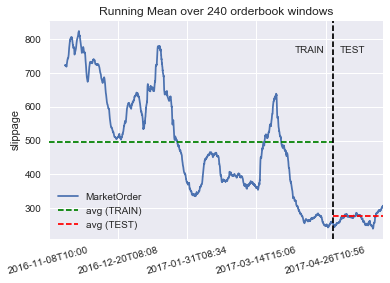

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=240,center=False).mean()


(0.0, 4832.0)


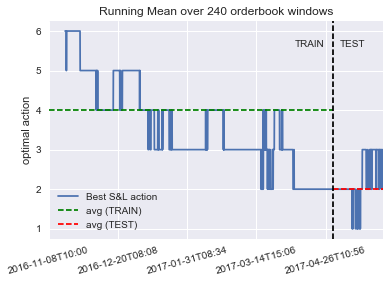

In [300]:
import datetime
fig, ax = plt.subplots()
df = pd.rolling_mean(costs_list_train.loc[:,'MarketOrder'], 240)
df.plot(rot=15, ax=ax)
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#plt.axhline(costs_list_train.loc[:'2017-05-01','MarketOrder'].mean(), label='avg (TRAIN)', color='green', linestyle='--')
mean_train = float(costs_list_train.loc[:'2017-05-01','MarketOrder'].mean())
mean_test = float(costs_list_train.loc['2017-05-01':,'MarketOrder'].mean())
plt.plot([0, 4109], [mean_train]*2, label='avg (TRAIN)', color='green', linestyle='--')
plt.plot([4109, len(df)], [mean_test]*2, label='avg (TEST)', color='red', linestyle='--')
plt.ylabel("slippage")
plt.axvline(4109, color='black', linestyle='--')
plt.text(3550, 760, 'TRAIN')
plt.text(4200, 760, 'TEST')
plt.legend(loc='best')
plt.title('Running Mean over 240 orderbook windows')
plt.savefig("runningMean240_MarketPrice.pdf")
print(ax.get_xlim())
plt.show()

fig, ax = plt.subplots()
df = pd.rolling_mean(costs_list_train.iloc[:,1:], 240).T.idxmin().astype(float)
df.plot(rot=15, ax=ax, label='Best S&L action')
mean_train = float(costs_list_train.iloc[:4109,1:].mean().idxmin())
mean_test = float(costs_list_train.iloc[4109:,1:].mean().idxmin())
plt.plot([0, 4109], [mean_train]*2, label='avg (TRAIN)', color='green', linestyle='--')
plt.plot([4109, len(df)], [mean_test]*2, label='avg (TEST)', color='red', linestyle='--')
plt.axvline(4109, color='black', linestyle='--')
plt.text(3550, 5.6, 'TRAIN')
plt.text(4200, 5.6, 'TEST')
plt.ylabel("optimal action")

plt.legend(loc='best')
plt.title('Running Mean over 240 orderbook windows')
print(ax.get_xlim())
#ax.set_xlim((0,4593.0))
plt.savefig("runningMean240_bestAction.pdf")
plt.show()

In [314]:
costs_list = [pd.read_csv("actions_slippage_nov.csv", index_col=0),
    pd.read_csv("actions_slippage_dec.csv", index_col=0),
    pd.read_csv("actions_slippage_jan.csv", index_col=0),
    pd.read_csv("actions_slippage_feb.csv", index_col=0),
    pd.read_csv("actions_slippage_mar.csv", index_col=0),
    pd.read_csv("actions_slippage_apr.csv", index_col=0),
#    pd.read_csv("actions_slippage_may.csv", index_col=0)
             ]

costs_list_train = pd.concat(
    costs_list
)

display(costs_list_train.mean())
plot_evaluation_costs(costs_list_train.iloc[:,:], name='Trainset (USDT-BTC)', hline='4', ylim=(-100,600), outfile='bestActionTrain.pdf', vlines=[1, 16])

# plot_evaluation_costs(pd.read_csv("actions_slippage_nov.csv", index_col=0).iloc[:,1:], name='Trainset (USDT-BTC)', hline='min', ylim=(-100, 600), vlines=[])

# for costs in costs_list:
#     plot_evaluation_costs(costs.iloc[:,1:], name='Trainset (USDT-BTC)', hline='min')

VolTime        180.018247
-4             439.786858
-3             430.497977
-2             415.588242
-1             391.459631
0              353.553192
1              287.688035
2              232.331553
3              204.383688
4              202.187817
5              214.728379
6              234.953244
7              258.822262
8              282.159118
9              304.104059
10             324.274586
MarketOrder    497.470882
dtype: float64

Saved figure to 'bestActionTrain.pdf'
